In [ ]:
# Importing some necessary libraries for our problem.
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, BatchNormalization, Activation, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random

from warnings import filterwarnings
filterwarnings("ignore")

In [ ]:
# Connecting to Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
train_path = r"/content/gdrive/MyDrive/PetImages/Train/"       # Folder url where train images are in.
test_path = r"/content/gdrive/MyDrive/PetImages/Test/"         # Folder url where train images are in.

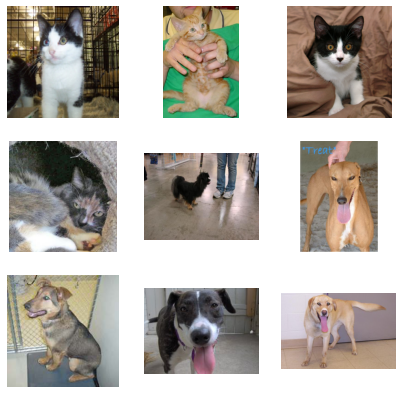

In [ ]:
# Lets see some images in train folder.
images = ["Cat/1000.jpg", "Cat/1001.jpg", "Cat/1002.jpg", "Cat/1003.jpg", 
          "Dog/1000.jpg", "Dog/1001.jpg", "Dog/1002.jpg", "Dog/1003.jpg", "Dog/1008.jpg"]

plt.figure(figsize=(7,7))
for i in range(len(images)):             # Totally 9 pictures will be shown.
  img = load_img(train_path + images[i]) # Loading images.
  plt.subplot(3,3,i+1)                   # Place the images on 3 rows, 3 columns.
  plt.imshow(img)                        # Show images.
  plt.axis("off")                        # Axis will not be shown.
plt.show()

In [ ]:
train_dataset = []
class_names = ["Cat", "Dog"]

def storing_images(dataset, class_names, path):
  """
  This function help us to load and store images from directories.
  """
  for category in class_names:  # Storing the images and labels by using for loop.
    folder = os.path.join(path, category)
    print(f"{category} images are loading...")
    label = class_names.index(category)

    for img in os.listdir(folder):
      try:                                            # Try and implement if no error.
        img_path = os.path.join(folder, img)
        img_arr = load_img(img_path)                  # Loading image.
        img_arr = img_to_array(img_arr)               # Converting the image to array.
        img_arr = cv2.resize(img_arr, (64, 64))       # Resizing all the images with (64, 64, 3) shape.
        dataset.append([img_arr, label])              # Adding image and label to dataset.
      except Exception as e:                          # Pass without giving error if image is invalid.
        pass
    print("Finished!")
  print(f"The dataset variable has {len(dataset)} images.")  

# Lets store images in train paths.
storing_images(train_dataset, class_names, train_path)

Cat images are loading...
Finished!
Dog images are loading...
Finished!
The dataset variable has 17561 images.


In [ ]:
def spliting_dataset(dataset):
  """
  This function helps us to split input data into image (X) and label (y) data.
  """
  random.shuffle(dataset)       # Shuffle the images together with their labels in the dataset.
  X = []                        # The images will be stored in X variable.
  y = []                        # The labels will be stored in y variable.
  for images, labels in dataset:
    X.append(images)            # Image in loop will be added to X variable
    y.append(labels)            # Label in loop will added to y variable.
  
  del dataset                   # deleting the dataset to save RAM because we don't need it any more.
  X = np.array(X)               # list to array.
  y = np.array(y).reshape(-1,1) # list to array with reshaping.

  return X, y
  
X, y = spliting_dataset(train_dataset)

In [ ]:
def normalization(data):
  """
  This function helps us to normalize input data.
  """
  data = data.astype("float32") / 255. # Image values will be divided with 255 because 255 is the biggest value in colors.
                                       # By doing so, image values will be between 0 and 1.
  return data

X = normalization(X)

In [ ]:
# It is time to split the X and y variables into X_train, y_train, X_val and y_val variables. 
# Validation datasets will be composed of 30% of all train dataset.

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=42)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)

X_train.shape: (12292, 64, 64, 3)
y_train.shape: (12292, 1)
X_val.shape: (5269, 64, 64, 3)
y_val.shape: (5269, 1)


Train dataset has 12292 images, whereas validation dataset has 5269 images

In [ ]:
vgg_model = VGG16(include_top = False,        # All layers in VGG16 Model will be taken.
                  weights = "imagenet",       # Weights trained on imagenet dataset will be taken.
                  input_shape = (64,64,3))    # Shape of the images in our dataset.

In [ ]:
# Layers in VGG16 Model should not be trained.
for layer in vgg_model.layers:
  layer.trainable = False                

# Last layer of VGG16 Model
last_conv_output = vgg_model.output      

# Flatten Layer
x = Flatten()(last_conv_output)

# First Hidden Layer with 128 Units
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.4)(x)

# Second Hidden Layer with 64 Units
x = Dense(64)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Output Layer with 1 Unit.
output = Dense(1, activation="sigmoid")(x)               

model = Model(inputs=vgg_model.input, outputs=output) # Merging layers.

In [ ]:
# Lets see the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [ ]:
# Model should be compiled before model training process.

model.compile(loss="binary_crossentropy",     # Our dataset has 2 labels (dog and cat). That is why the loss function should be binary crossentropy.
              optimizer="rmsprop",               # Optimizer is Adam.
              metrics=["accuracy"])           # Evaluation metric for model training is accuracy.

In [ ]:
# If no longer improvement during model training process, the process will stop in order not to waste time.
early_stopping = EarlyStopping(patience=5,                  # Model will be checked in every 5 epochs.
                               restore_best_weights=True,   # Best weights will be saved to be used.
                               monitor="val_loss")          # Validation loss of model will be checked.

# Model training process will start by calling fit function.
hist = model.fit(X_train, y_train, batch_size=128, # The model will be trained with train_generator data.
                 epochs=50,                        # 100 training iterations will take place.
                 validation_data=(X_val, y_val),   # The model performance will be measured and validated with train_generator data.
                 callbacks=[early_stopping],       # Early stopping will be implemented as callbacks.
                 verbose=1)

Epoch 1/50
97/97 [==============================] - 9s 85ms/step - loss: 0.5023 - accuracy: 0.7574 - val_loss: 0.4071 - val_accuracy: 0.8108
Epoch 2/50
97/97 [==============================] - 8s 79ms/step - loss: 0.3858 - accuracy: 0.8248 - val_loss: 0.4266 - val_accuracy: 0.7935
Epoch 3/50
97/97 [==============================] - 8s 82ms/step - loss: 0.3524 - accuracy: 0.8432 - val_loss: 0.5028 - val_accuracy: 0.7677
Epoch 4/50
97/97 [==============================] - 8s 80ms/step - loss: 0.3256 - accuracy: 0.8569 - val_loss: 0.4295 - val_accuracy: 0.8038
Epoch 5/50
97/97 [==============================] - 8s 82ms/step - loss: 0.3036 - accuracy: 0.8701 - val_loss: 0.4546 - val_accuracy: 0.8019
Epoch 6/50
97/97 [==============================] - 8s 81ms/step - loss: 0.2818 - accuracy: 0.8801 - val_loss: 0.4881 - val_accuracy: 0.7886


The model training process has been stopped in 6th epochs due to no more improvement in validation loss. What we can do;
* Increasing the number of the "patience" parameter (like 10).
* The model has overfitting. We can do some regularization like augmenting the images, or adding l2 regularization parameter to penalize weights.
* Changing VGG16 with an appropriate one of other neural network architectures.

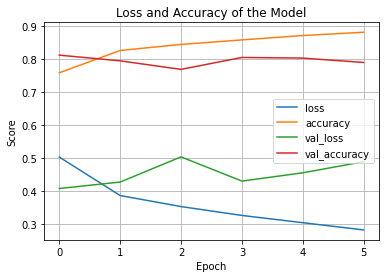

In [ ]:
# Visualizing the model training process on plot.
pd.DataFrame(hist.history).plot()
plt.title("Loss and Accuracy of the Model")   # Title of the plot.
plt.xlabel("Epoch")                           # X axis represents each epoch number.
plt.ylabel("Score")                           # Y axis represents loss and accuracy scores.
plt.grid()
plt.show()

In [ ]:
# Lets save the model's weights with .h5 format.
model.save_weights("vgg16_cat_and_dog.h5")

In [ ]:
# It is now time to measure generalization error of the model on test dataset which model has not seen by now.
test_dataset = []
storing_images(test_dataset, class_names, test_path)  # Images and labels in test folder will be stored in test_dataset variable. 
X_test, y_test = spliting_dataset(test_dataset)       # test_dataset variable will be split into X_test (images) and y_test (labels).
X_test = normalization(X_test)                        # Normalizing image values. 

Cat images are loading...
Finished!
Dog images are loading...
Finished!
The dataset variable has 4999 images.


In [ ]:
# Lets evaluate the model on test images.
loss, accuracy = model.evaluate(X_test, y_test, batch_size=128)
print("Loss:", loss)
print("Accuracy:", accuracy)

40/40 [==============================] - 3s 64ms/step - loss: 0.4465 - accuracy: 0.7864
Loss: 0.4464934468269348
Accuracy: 0.7863572835922241


Test accuracy is close to validation accuracy.